In [1]:
from __future__ import division, print_function
%matplotlib inline
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'nearest'

# Image processing and machine learning

Some image processing numerical techniques are very specific to image processing, such as mathematical morphology or anisotropic diffusion segmentation. However, it is also possible to adapt generic machine learning techniques for image processing.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Thresholding and color quantization

Image binarization is a common operation. For grayscale images, finding the best threshold for binarization can be a manual operation. Alternatively, algorithms can select a threshold value automatically; which is convenient for computer vision, or for batch-processing a series of images.

In [3]:
from skimage import data, exposure, filters
camera = data.camera()

In [4]:
hi = exposure.histogram(camera)

In [5]:
val = filters.threshold_otsu(camera)

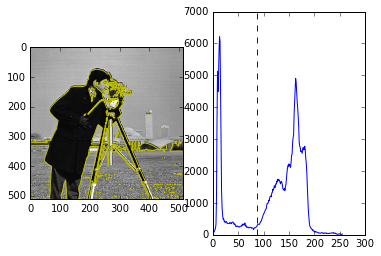

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(camera, cmap='gray')
axes[0].contour(camera, [val], colors='y')
axes[1].plot(hi[1], hi[0])
axes[1].axvline(val, ls='--')

Otsu thresholding is equivalent to *clustering* pixels in two groups.[explain more]

In [7]:
from skimage import io, color
im = io.imread('../images/round_pill.jpg')


In [8]:
# justify lab colorspace
im_lab = color.rgb2lab(im)
data = np.array([im_lab[..., 1].ravel(), im_lab[..., 2].ravel()])

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(data.T)
segmentation = kmeans.labels_.reshape(im.shape[:-1])

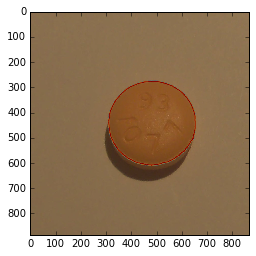

In [10]:
plt.imshow(im)
plt.contour(segmentation)

In [11]:
im = io.imread('../images/chapel_floor.png')
im_lab = color.rgb2lab(im)
data = np.array([im_lab[..., 0].ravel(),
                 im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=4, random_state=0).fit(data.T)
segmentation = kmeans.labels_.reshape(im.shape[:-1])

(-0.5, 375.5, 276.5, -0.5)

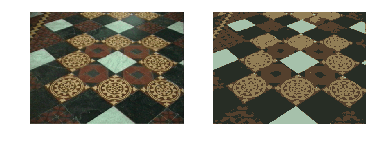

In [12]:
color_mean = color.label2rgb(segmentation, im, kind='mean')
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[0].axis('off')
axes[1].imshow(color_mean)
axes[1].axis('off')

Add here something about png compression levels

## SLIC algorithm: clustering using color and spatial features

In the thresholding / vector approach presented above, pixels are characterized only by their color features. However, in most images neighboring pixels correspond to the same object. Hence, information on spatial proximity between pixels can be used in addition to color information.

SLIC (Simple Linear Iterative Clustering) is a segmentation algorithm which clusters pixels in both space and color. Therefore, regions of space that are similar in color will end up in the same segment.

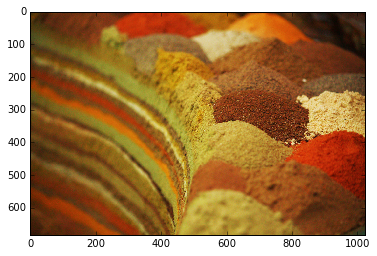

In [13]:
spices = io.imread('../images/spices.jpg')
plt.imshow(spices)

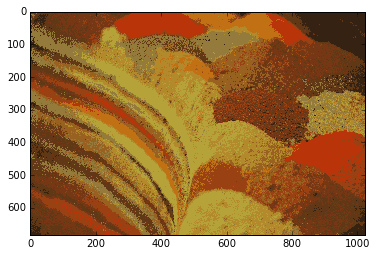

In [14]:
im_lab = color.rgb2lab(spices)
data = np.array([im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=10, random_state=0).fit(data.T)
labels = kmeans.labels_.reshape(spices.shape[:-1])
color_mean = color.label2rgb(labels, spices, kind='mean')
plt.imshow(color_mean)

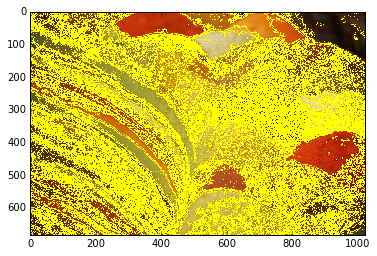

In [15]:
from skimage import segmentation
plt.imshow(segmentation.mark_boundaries(spices, labels))

In [16]:
from skimage import segmentation
segments = segmentation.slic(spices, n_segments=200, compactness=20)

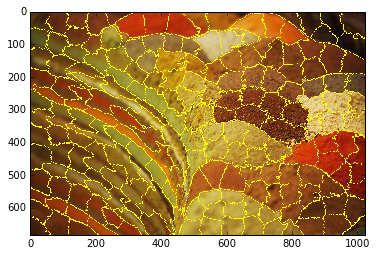

In [17]:
plt.imshow(segmentation.mark_boundaries(spices, segments))

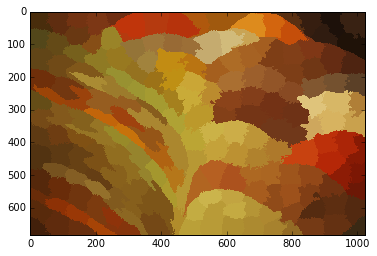

In [18]:
result = color.label2rgb(segments, spices, kind='mean')
plt.imshow(result)

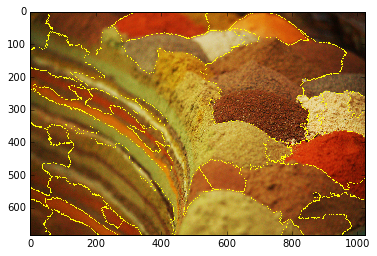

In [24]:
# This could be improved
im_lab = color.rgb2lab(result)
data = np.array([im_lab[..., 1].ravel(),
                 im_lab[..., 2].ravel()])

kmeans = KMeans(n_clusters=5, random_state=0).fit(data.T)
labels = kmeans.labels_.reshape(spices.shape[:-1])
color_mean = color.label2rgb(labels, spices, kind='mean')
plt.imshow(segmentation.mark_boundaries(spices, labels))

## Increasing the number of low-level features: trained segmentation using Gabor filters and random forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from skimage import filters
from skimage import img_as_float

def _compute_features(im):
    gabor_frequencies = np.logspace(-3, 2, num=6, base=2)
    thetas = [0, np.pi/2]
    nb_fq = len(gabor_frequencies) * len(thetas)
    im = np.atleast_3d(im)
    im_gabor = np.empty((im.shape[-1], nb_fq) + im.shape[:2])
    for ch in range(im.shape[-1]):
        img = img_as_float(im[..., ch])
        for i_fq, fq in enumerate(gabor_frequencies):
            for i_th, theta in enumerate(thetas):
                tmp = filters.gabor(img, fq, theta=theta)
                im_gabor[ch, len(thetas) * i_fq + i_th] = \
                                    np.abs(tmp[0] + 1j * tmp[1])
    return im_gabor


def trainable_segmentation(im, mask):
    """
    Parameters
    ----------
    
    im : ndarray
        2-D image (grayscale or RGB) to be segmented
        
    mask : ndarray of ints
        Array of labels. Non-zero labels are known regions that are used
        to train the classification algorithm.
    """
    # Define features
    im_gabor = _compute_features(im)     
    training_data = im_gabor[:, :, mask>0].reshape((im.shape[-1] * nb_fq,
                                                    (mask>0).sum())).T
    training_labels = mask[mask>0].ravel()
    data = im_gabor[:, :, mask == 0].reshape((im.shape[-1] * nb_fq,
                                              (mask == 0).sum())).T
    # classification
    clf = RandomForestClassifier()
    clf.fit(training_data, training_labels)
    labels = clf.predict(data)
    result = np.copy(mask)
    result[mask == 0] = labels
    return result

In [ ]:
# Image from https://fr.wikipedia.org/wiki/Fichier:Bells-Beach-View.jpg
beach = io.imread('../images/Bells-Beach.jpg')
plt.imshow(beach)

In [ ]:
mask = np.zeros(beach.shape[:-1], dtype=np.uint8)
mask[700:] = 1
mask[:550, :650] = 2
mask[400:450, 1000:1100] = 3
plt.imshow(beach)
plt.contour(mask)

In [ ]:
result = trainable_segmentation(beach, mask)
plt.imshow(color.label2rgb(result, beach, kind='mean'))

## Using mid-level features 

[Panorama stitching](adv3_panorama-stitching.ipynb)